<a href="https://colab.research.google.com/github/Zabihuddin/data_analysis/blob/main/ddos__Attack_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-1-7569343e0ea3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'pkt_rate'] = dataset['pktcount'] / dataset['dur']
<ipython-input-1-7569343e0ea3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'byte_rate'] = dataset['bytecount'] / dataset['dur']
<ipython-input-1-7569343e0ea3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Detected DDoS Events:
                      dt  switch        src       dst  pktcount  bytecount  \
5834 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5835 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5836 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5837 1970-01-01 03:15:55       3  10.0.0.10  10.0.0.8    109997    1000000   
5838 1970-01-01 03:11:55       3   10.0.0.1  10.0.0.8     85573    1000000   

      dur   dur_nsec       tot_dur  flows  ...    pkt_rate      byte_rate  \
5834  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5835  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5836  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5837  380  560000000  3.810000e+11      2  ...  289.465789  301623.352632   
5838  190  299000000  1.900000e+11      5  ...  450.384211  480109.568421   

      flow_rate  rolling_pkt_rate  rolling_byt

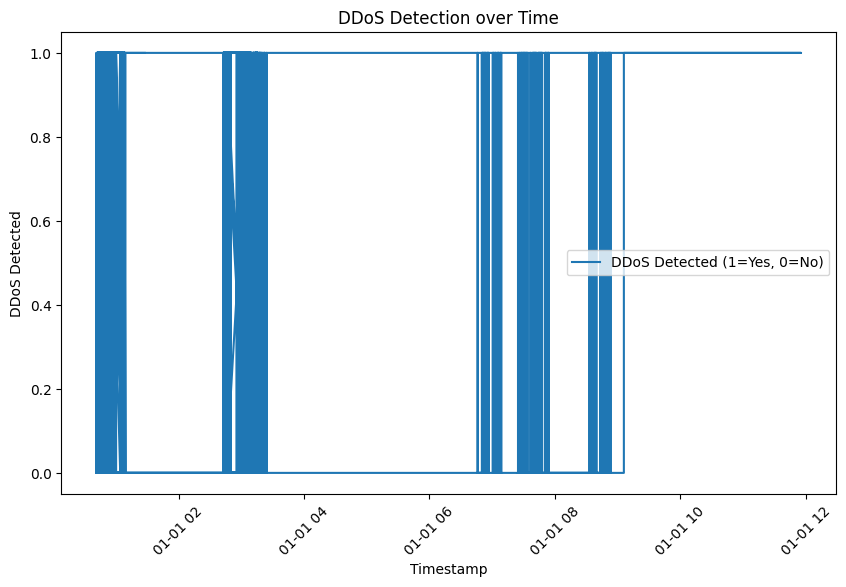

✅ Detected DDoS events saved as 'detected_ddos_events.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Load the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv'
dataset = pd.read_csv(file_path)

### --------------------- Step 1: Data Preprocessing --------------------- ###
# Convert timestamp column 'dt' to datetime format (if exists)
dataset['dt'] = pd.to_datetime(dataset['dt'], unit='s')

# Handle missing values
numeric_columns = dataset.select_dtypes(include=[np.number]).columns
dataset.loc[:, numeric_columns] = dataset[numeric_columns].fillna(dataset[numeric_columns].mean())

non_numeric_columns = dataset.select_dtypes(exclude=[np.number]).columns
dataset.loc[:, non_numeric_columns] = dataset[non_numeric_columns].fillna('unknown')

# Drop duplicates
dataset = dataset.drop_duplicates()

### --------------------- Step 2: Feature Engineering --------------------- ###
# Step 2: Feature Engineering
dataset.loc[:, 'pkt_rate'] = dataset['pktcount'] / dataset['dur']
dataset.loc[:, 'byte_rate'] = dataset['bytecount'] / dataset['dur']
dataset.loc[:, 'flow_rate'] = dataset['flows'] / dataset['dur']

# Add rolling statistics features
dataset.loc[:, 'rolling_pkt_rate'] = dataset['pkt_rate'].rolling(window=10).mean()
dataset.loc[:, 'rolling_byte_rate'] = dataset['byte_rate'].rolling(window=10).mean()

### --------------------- Step 3: Handle Extreme Values (Inf and NaN) --------------------- ###
features = ['pktcount', 'bytecount', 'flows', 'pkt_rate', 'byte_rate', 'flow_rate']
dataset.loc[:, features] = dataset[features].replace([np.inf, -np.inf], np.nan).fillna(dataset[features].max())
dataset.loc[:, features] = dataset[features].clip(upper=1e6)

# Ensure there are no NaN or Inf values left
assert dataset[features].isna().sum().sum() == 0, "There are still NaN values in the dataset"

### --------------------- Step 4: Scaling the Data --------------------- ###
scaler = RobustScaler()
X_scaled = scaler.fit_transform(dataset[features])

### --------------------- Step 5: Anomaly Detection Using Z-Scores --------------------- ###
dataset.loc[:, 'z_pkt_rate'] = zscore(dataset['pkt_rate'])
dataset.loc[:, 'z_byte_rate'] = zscore(dataset['byte_rate'])
dataset.loc[:, 'potential_ddos_pkt'] = dataset['z_pkt_rate'].apply(lambda x: 1 if abs(x) > 3 else 0)
dataset.loc[:, 'potential_ddos_byte'] = dataset['z_byte_rate'].apply(lambda x: 1 if abs(x) > 3 else 0)

### --------------------- Step 6: Handling Class Imbalance (SMOTE) --------------------- ###
X = dataset[features]
y = dataset['potential_ddos_pkt'] | dataset['potential_ddos_byte']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### --------------------- Step 7: Training Multiple Models for Anomaly Detection --------------------- ###
# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_resampled)
y_pred_iso = iso_forest.predict(X_resampled)

# One-Class SVM
one_class_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
one_class_svm.fit(X_resampled)
y_pred_svm = one_class_svm.predict(X_resampled)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred_lof = lof.fit_predict(X_resampled)

# Convert model output: -1 = anomaly, 1 = normal
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

### --------------------- Step 8: Combine Anomaly Flags and Detect DDoS Events --------------------- ###
final_detection = y_pred_iso | y_pred_svm | y_pred_lof | y_resampled

# Show the detected DDoS events
ddos_events = dataset.iloc[:len(y_resampled)]  # Make sure we are selecting the same number of rows as in the resampled data
ddos_events['final_detection'] = final_detection
ddos_events = ddos_events[ddos_events['final_detection'] == 1]

# Display detected DDoS events
print("Detected DDoS Events:")
print(ddos_events.head())

### --------------------- Step 9: Evaluate the Model Performance --------------------- ###
print("Model Evaluation Metrics:")
print(classification_report(y_resampled, final_detection))

### --------------------- Step 10: Plot DDoS Detection over Time --------------------- ###
# We now use the resampled data `y_resampled` and corresponding indices
resampled_index = np.linspace(0, len(dataset) - 1, num=len(y_resampled)).astype(int)
resampled_index = np.clip(resampled_index, 0, len(dataset) - 1)
resampled_dt = dataset.iloc[resampled_index]['dt'].reset_index(drop=True)

# Ensure `final_detection` has the same shape
final_detection = final_detection[:len(resampled_dt)]

# Now plot the graph
plt.figure(figsize=(10, 6))
plt.plot(resampled_dt, final_detection, label='DDoS Detected (1=Yes, 0=No)')
plt.title("DDoS Detection over Time")
plt.xlabel("Timestamp")
plt.ylabel("DDoS Detected")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### --------------------- Optional: Save the Detected DDoS Events to a CSV --------------------- ###
ddos_events.to_csv('detected_ddos_events.csv', index=False)
print("✅ Detected DDoS events saved as 'detected_ddos_events.csv'.")


✅ Detected DDoS events saved as 'detected_ddos_attacks.csv'.


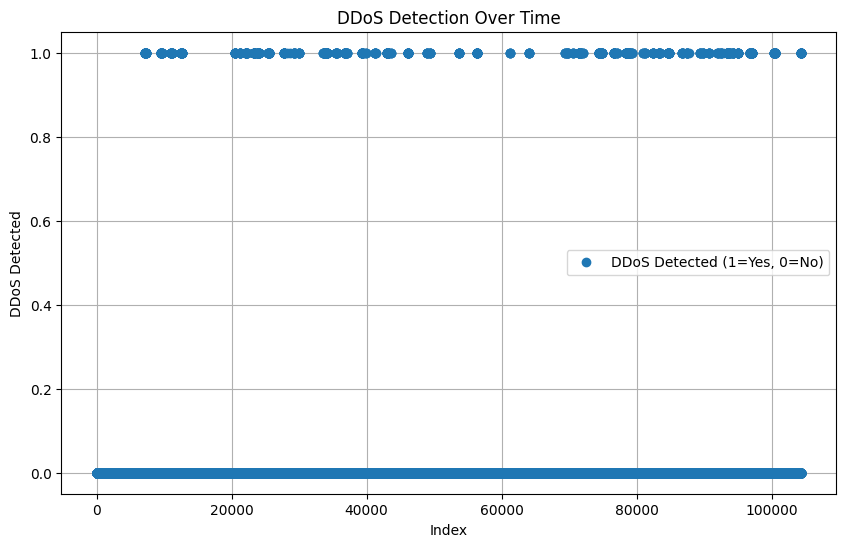

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Load the dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv"  # Update the correct path
dataset = pd.read_csv(file_path)

### --------------------- Step 1: Data Preprocessing --------------------- ###
# Convert timestamp column 'dt' to datetime format (if exists)
if 'dt' in dataset.columns:
    dataset['dt'] = pd.to_datetime(dataset['dt'], unit='s', errors='coerce')

# Select only numeric columns (remove non-numeric like IPs & Protocols)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
dataset = dataset[numeric_cols]

# Remove duplicate and missing values
dataset.dropna(inplace=True)  # Drop rows with missing values
dataset.drop_duplicates(inplace=True)  # Drop duplicate rows

# Fixing zero division errors by replacing 0 in 'dur' column with NaN
if 'dur' in dataset.columns:
    dataset.loc[dataset['dur'] == 0, 'dur'] = np.nan  # Correct way to modify DataFrame
    dataset.dropna(subset=['dur'], inplace=True)  # Drop rows where 'dur' is NaN

### --------------------- Step 2: Feature Engineering --------------------- ###
# Compute network traffic rates
dataset['pkt_rate'] = dataset['pktcount'] / dataset['dur']
dataset['byte_rate'] = dataset['bytecount'] / dataset['dur']
dataset['flow_rate'] = dataset['flows'] / dataset['dur']

# Replace infinite values with NaN and then fill them with median values
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(dataset.median(numeric_only=True), inplace=True)

### --------------------- Step 3: Statistical Analysis (Z-score) --------------------- ###
# Calculate Z-score to detect outliers in packet & byte rates
dataset['z_pkt_rate'] = zscore(dataset['pkt_rate'])
dataset['z_byte_rate'] = zscore(dataset['byte_rate'])

# Flag potential DDoS based on Z-score threshold (absolute value > 3)
dataset['potential_ddos_pkt'] = (dataset['z_pkt_rate'].abs() > 3).astype(int)
dataset['potential_ddos_byte'] = (dataset['z_byte_rate'].abs() > 3).astype(int)

### --------------------- Step 4: Machine Learning Model (Isolation Forest) --------------------- ###
# Define features to be used for anomaly detection
features = ['pkt_rate', 'byte_rate', 'flow_rate']
X = dataset[features]

# Standardize the features (important for ML models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Isolation Forest model (detects anomalies)
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% contamination assumed
dataset['ddos_anomaly'] = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 for easier understanding
dataset['ddos_anomaly'] = (dataset['ddos_anomaly'] == -1).astype(int)

### --------------------- Step 5: Traffic Flow Monitoring --------------------- ###
# Identify high flow rate sessions (top 1% of flow rates)
high_flow_sessions = dataset[dataset['flow_rate'] > dataset['flow_rate'].quantile(0.99)]

# Identify high packet count sessions (top 1%)
pkt_threshold = dataset['pktcount'].quantile(0.99)
high_pkt_sessions = dataset[dataset['pktcount'] > pkt_threshold]

### --------------------- Step 6: Final DDoS Detection --------------------- ###
# Combine multiple indicators for robust DDoS detection
dataset['final_ddos_detection'] = (
    dataset['ddos_anomaly'] | dataset['potential_ddos_pkt'] | dataset['potential_ddos_byte']
)

# Extract only detected DDoS attack instances
ddos_events = dataset[dataset['final_ddos_detection'] == 1]

### --------------------- Step 7: Save & Display Results --------------------- ###
# Save detected DDoS attacks to CSV for review
ddos_events.to_csv("/content/detected_ddos_attacks.csv", index=False)
print("✅ Detected DDoS events saved as 'detected_ddos_attacks.csv'.")

# Plot the DDoS detection results over time
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['final_ddos_detection'], label='DDoS Detected (1=Yes, 0=No)', marker='o', linestyle='')
plt.title("DDoS Detection Over Time")
plt.xlabel("Index")
plt.ylabel("DDoS Detected")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
!pip install seaborn

In [ ]:
print(data.head())

      dt  switch       src       dst  pktcount  bytecount  dur   dur_nsec  \
0  11425       1  10.0.0.1  10.0.0.8     45304   48294064  100  716000000   
1  11605       1  10.0.0.1  10.0.0.8    126395  134737070  280  734000000   
2  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
3  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
4  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   

        tot_dur  flows  ...  pktrate  Pairflow  Protocol  port_no   tx_bytes  \
0  1.010000e+11      3  ...      451         0         2        3  143928631   
1  2.810000e+11      2  ...      451         0         2        4       3842   
2  2.010000e+11      3  ...      451         0         2        1       3795   
3  2.010000e+11      3  ...      451         0         2        2       3688   
4  2.010000e+11      3  ...      451         0         2        3       3413   

   rx_bytes  tx_kbps  rx_kbps  tot_kbps  label  
0      

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  int64  
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [ ]:
print(data.describe())

                  dt         switch       pktcount     bytecount  \
count  104345.000000  104345.000000  104345.000000  1.043450e+05   
mean    17927.514169       4.214260   52860.954746  3.818660e+07   
std     11977.642655       1.956327   52023.241460  4.877748e+07   
min      2488.000000       1.000000       0.000000  0.000000e+00   
25%      7098.000000       3.000000     808.000000  7.957600e+04   
50%     11905.000000       4.000000   42828.000000  6.471930e+06   
75%     29952.000000       5.000000   94796.000000  7.620354e+07   
max     42935.000000      10.000000  260006.000000  1.471280e+08   

                 dur      dur_nsec       tot_dur          flows  \
count  104345.000000  1.043450e+05  1.043450e+05  104345.000000   
mean      321.497398  4.613880e+08  3.218865e+11       5.654234   
std       283.518232  2.770019e+08  2.834029e+11       2.950036   
min         0.000000  0.000000e+00  0.000000e+00       2.000000   
25%       127.000000  2.340000e+08  1.270000e+11    

In [ ]:
print(data.isnull().sum())  # Check missing values
data = data.dropna()  # Drop rows with missing values


dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64


In [ ]:
data['Protocol'] = data['Protocol'].astype('category').cat.codes  # Convert to numeric


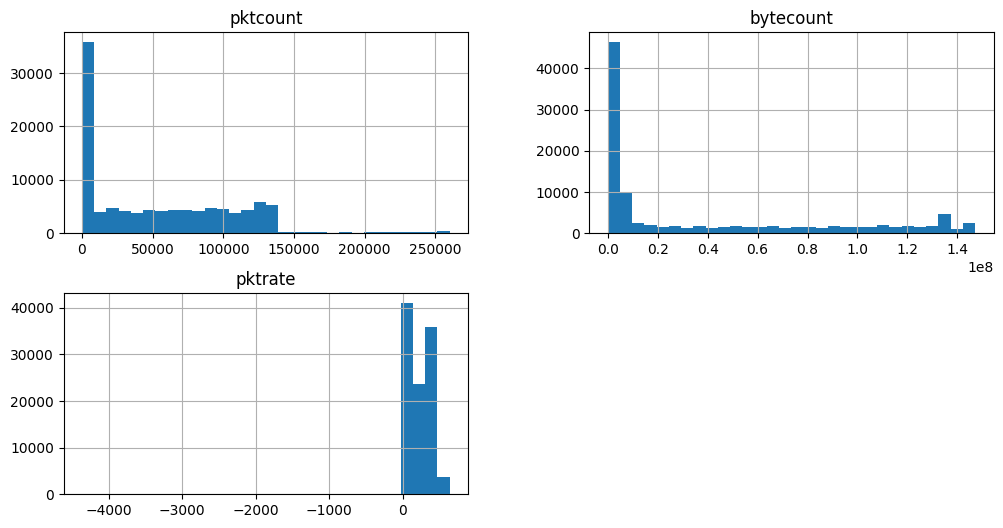

In [ ]:
data[['pktcount', 'bytecount', 'pktrate']].hist(bins=30, figsize=(12, 6))
plt.show()


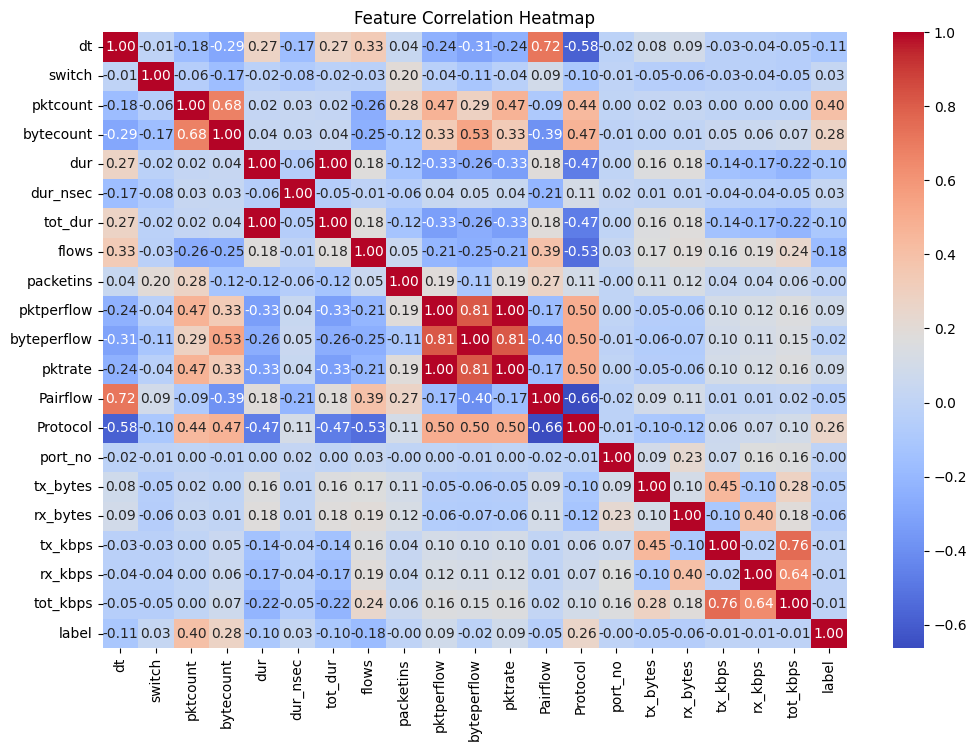

In [ ]:
numerical_data = data.select_dtypes(include=np.number) # Select only numerical columns for correlation
corr = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


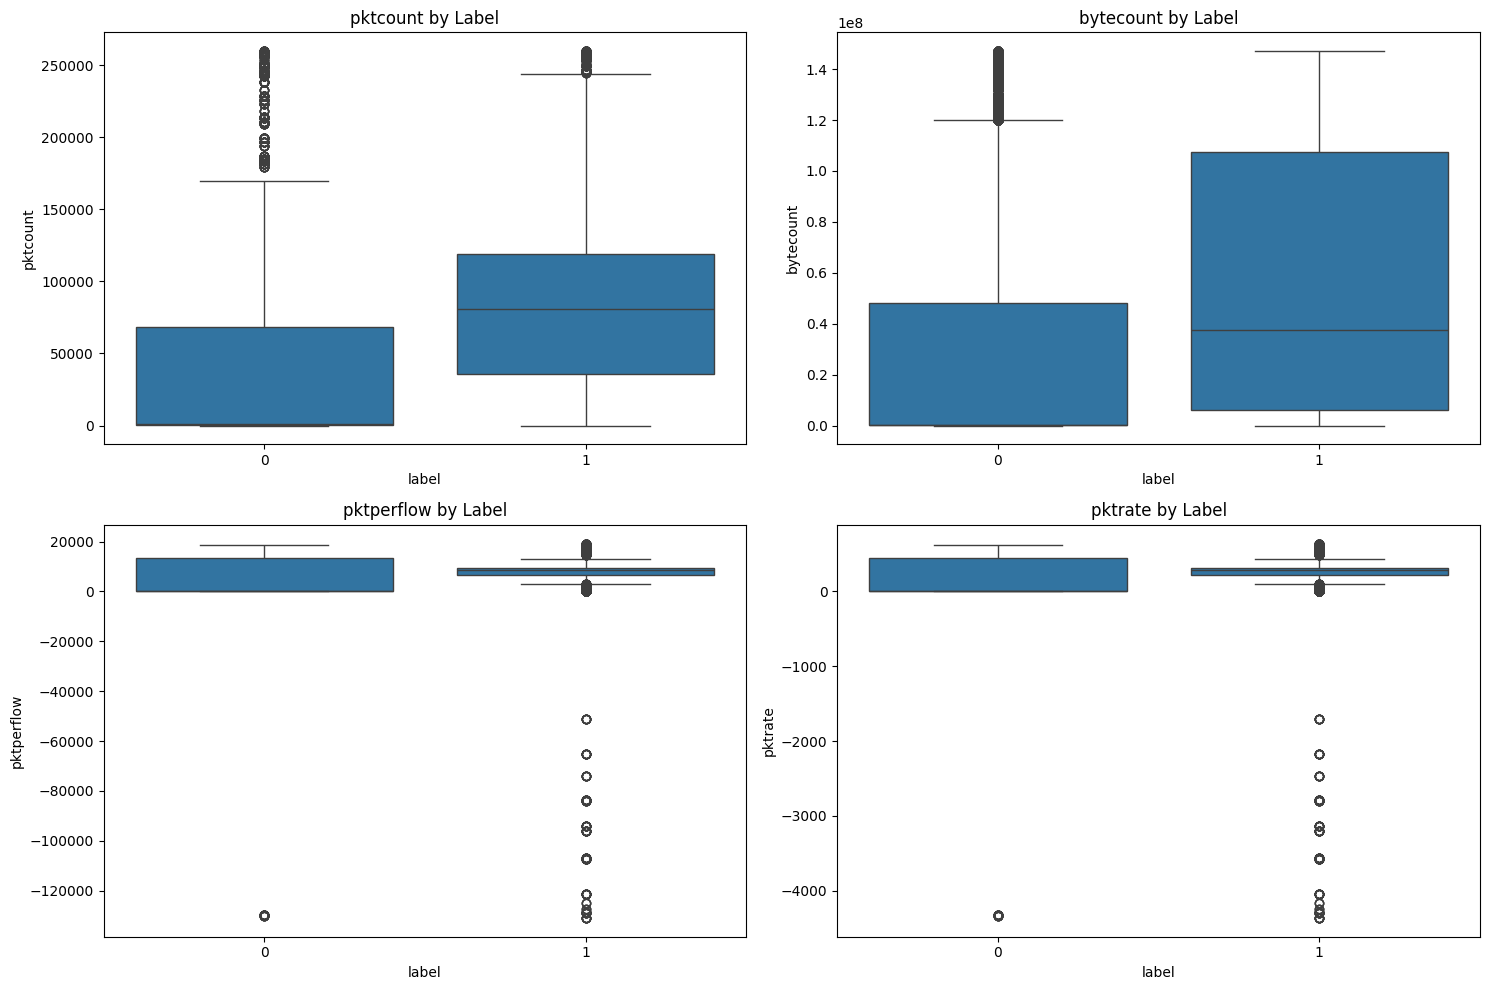

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(['pktcount', 'bytecount', 'pktperflow', 'pktrate']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='label', y=col, data=data)
    plt.title(f'{col} by Label')
plt.tight_layout()
plt.show()

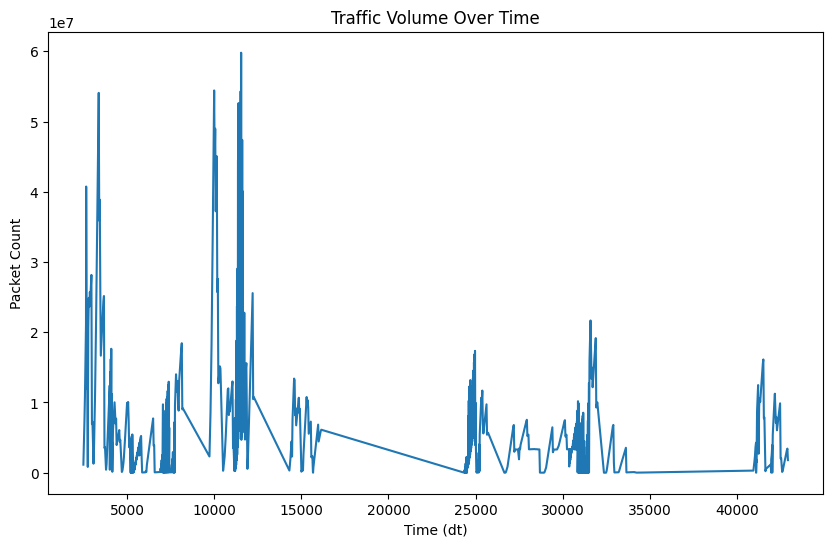

In [ ]:
plt.figure(figsize=(10, 6))
data.groupby('dt')['pktcount'].sum().plot(kind='line')
plt.title('Traffic Volume Over Time')
plt.xlabel('Time (dt)')
plt.ylabel('Packet Count')
plt.show()


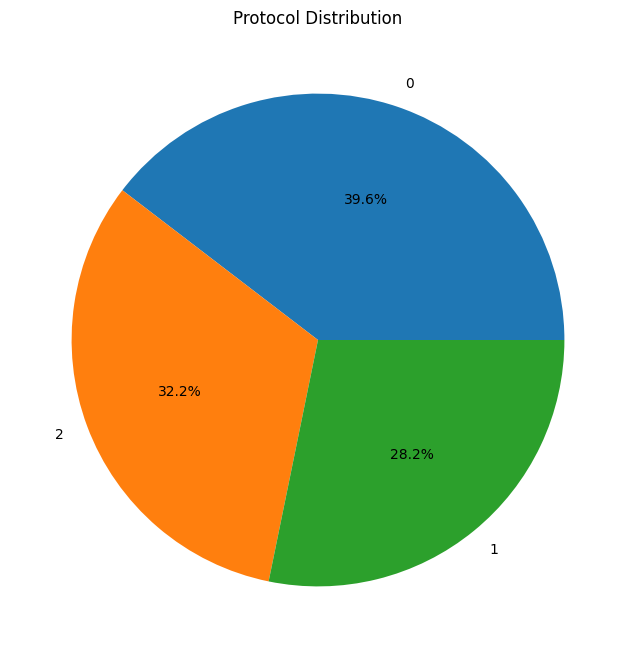

In [ ]:
protocol_counts = data['Protocol'].value_counts()
protocol_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Protocol Distribution')
plt.ylabel('')
plt.show()

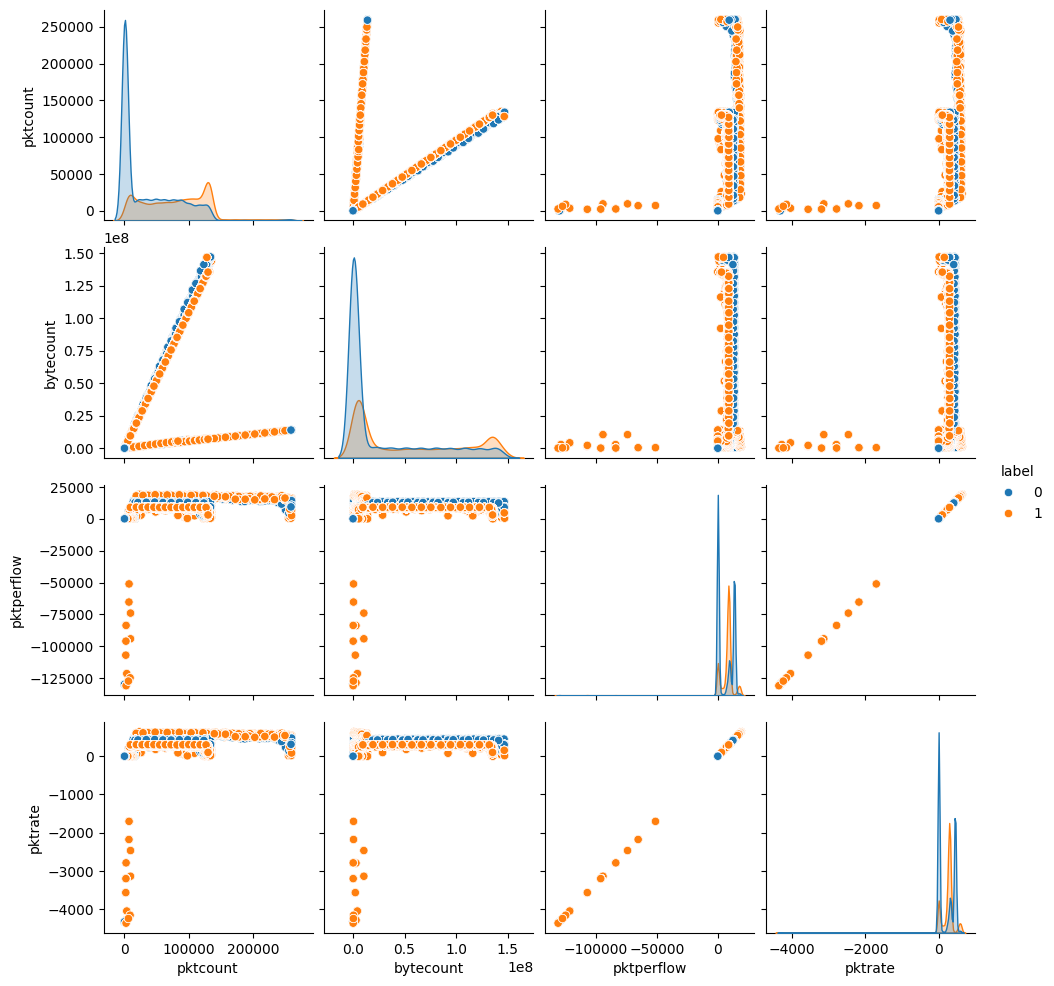

In [ ]:
sns.pairplot(data[['pktcount', 'bytecount', 'pktperflow', 'pktrate', 'label']], hue='label', diag_kind='kde')
plt.show()


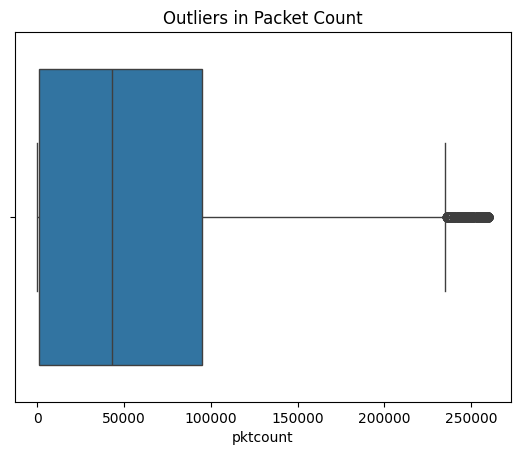

In [ ]:
sns.boxplot(x=data['pktcount'])
plt.title('Outliers in Packet Count')
plt.show()

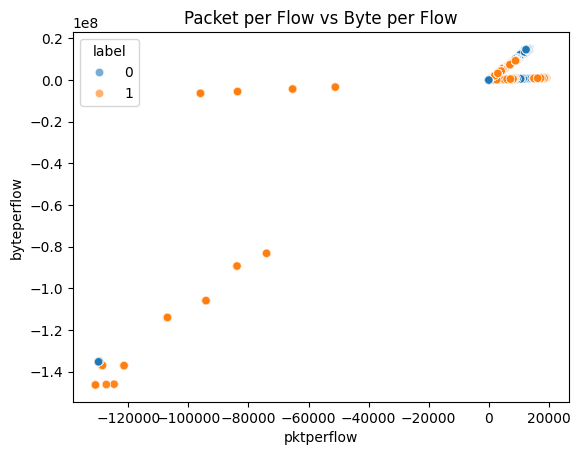

In [ ]:
sns.scatterplot(data=data, x='pktperflow', y='byteperflow', hue='label', alpha=0.6)
plt.title('Packet per Flow vs Byte per Flow')
plt.show()


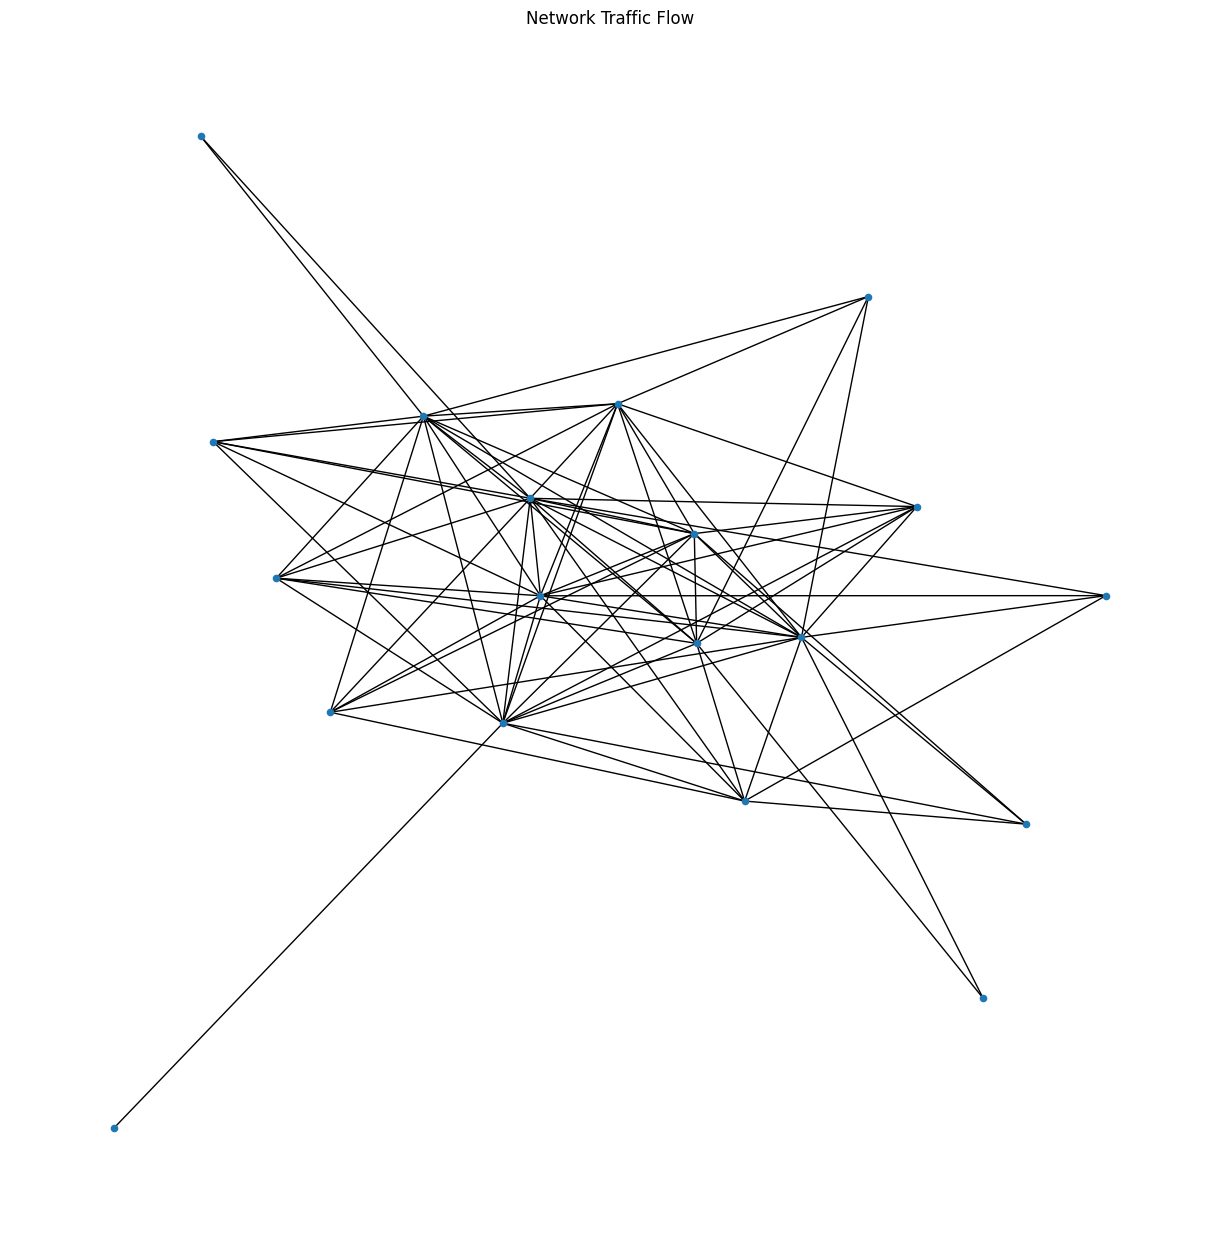

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(data, source='src', target='dst', edge_attr=True)
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=20)
plt.title('Network Traffic Flow')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout

# Load and preprocess the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv'
data = pd.read_csv(file_path)

# Handle missing values if any
data.fillna(0, inplace=True)

# Encode categorical variables (if any)
label_encoder = LabelEncoder()
data['Protocol'] = label_encoder.fit_transform(data['Protocol'])

# Features and target selection
X = data.drop(['label', 'src', 'dst'], axis=1)
y = data['label']

# Normalize the feature set
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Machine Learning Models
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

# 2. Deep Learning Models
# CNN
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2)
cnn_accuracy = cnn_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1]
print("CNN Accuracy:", cnn_accuracy)

# LSTM
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2)
lstm_accuracy = lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1]
print("LSTM Accuracy:", lstm_accuracy)

# 3. Hybrid Model: CNN-LSTM
cnn_lstm_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    LSTM(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2)
cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1]
print("CNN-LSTM Accuracy:", cnn_lstm_accuracy)

# 4. Statistical Analysis
# Simple threshold-based anomaly detection
threshold = X_train.mean(axis=0) + 3 * X_train.std(axis=0)
anomaly_scores = np.sum((X_test > threshold), axis=1)
stats_preds = (anomaly_scores > np.mean(anomaly_scores)).astype(int)
print("Statistical Model Accuracy:", accuracy_score(y_test, stats_preds))

# Generate a comprehensive report for all models
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_preds))
print("Classification Report for CNN:")
cnn_preds = (cnn_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten()
print(classification_report(y_test, cnn_preds))


Random Forest Accuracy: 1.0
SVM Accuracy: 0.9702429440797355
KNN Accuracy: 0.9758014279553404
XGBoost Accuracy: 1.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9278 - loss: 0.1729 - val_accuracy: 0.9787 - val_loss: 0.0589
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9777 - loss: 0.0600 - val_accuracy: 0.9869 - val_loss: 0.0398
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9851 - loss: 0.0392 - val_accuracy: 0.9884 - val_loss: 0.0310
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9882 - loss: 0.0313 - val_accuracy: 0.9923 - val_loss: 0.0222
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9900 - loss: 0.0251 - val_accuracy: 0.9901 - val_loss: 0.0239
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9902 - loss: 0.0247 - val_accuracy: 0.9928 - val_loss: 0.0189
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9929 - loss: 0.0203 - val_accuracy: 0.9893 - val_loss: 0.0292
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9923 - loss: 0.0223

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2087/2087 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7494 - loss: 0.4888 - val_accuracy: 0.9127 - val_loss: 0.1991
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.9256 - loss: 0.1767 - val_accuracy: 0.9417 - val_loss: 0.1400
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9417 - loss: 0.1340 - val_accuracy: 0.9547 - val_loss: 0.1070
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9547 - loss: 0.1096 - val_accuracy: 0.9644 - val_loss: 0.0891
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.9665 - loss: 0.0844 - val_accuracy: 0.9747 - val_loss: 0.0665
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9729 - loss: 0.0689 - val_accuracy: 0.9824 - val_loss: 0.0478
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9780 - loss: 0.0565 - val_accuracy: 0.9795 - val_loss: 0.0507
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9800 - loss: 0.05

In [ ]:
# Autoencoder for Anomaly Detection
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define input dimensions
input_dim = X_train.shape[1]

# Define the layers of the Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Create the Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Use the Autoencoder for Anomaly Detection
# Reconstruct the test set
X_test_reconstructed = autoencoder.predict(X_test)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# Define a threshold for anomaly detection (can be fine-tuned)
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)

# Make predictions: 1 for anomaly, 0 for normal
autoencoder_preds = (reconstruction_error > threshold).astype(int)

# Evaluate the performance
print("Autoencoder Accuracy:", accuracy_score(y_test, autoencoder_preds))
print("Classification Report for Autoencoder:")
print(classification_report(y_test, autoencoder_preds))


Epoch 1/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6715 - val_loss: 0.5417
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5414 - val_loss: 0.5396
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.5494 - val_loss: 0.5392
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5335 - val_loss: 0.5387
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5479 - val_loss: 0.5388
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5438 - val_loss: 0.5388
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5425 - val_loss: 0.5385
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5372 - val_loss: 0.5382
Epoch 9/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5399 - val_loss: 0.5384
Epoch 10/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5462 - val_loss: 0.5383
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Autoencoder Accuracy: 0.6111457185298769
Classification Report for Autoencoder

Visualizing Machine Learning Models:


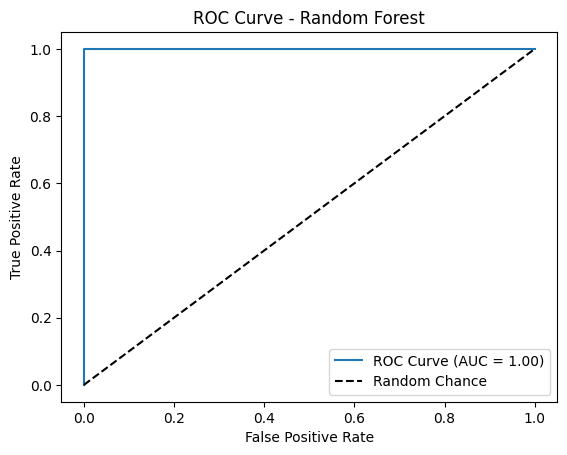

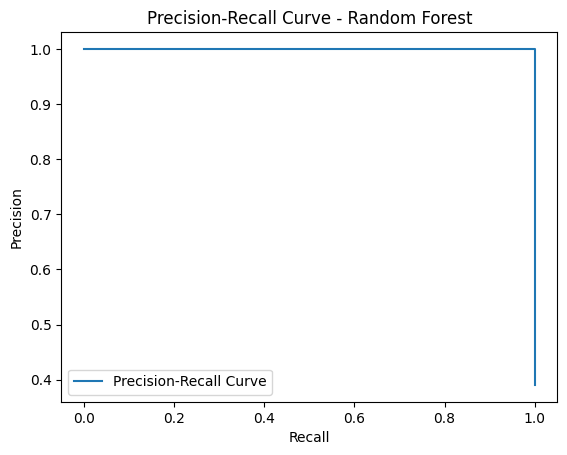

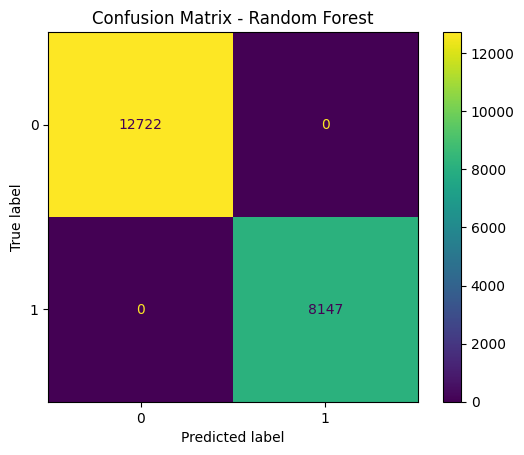

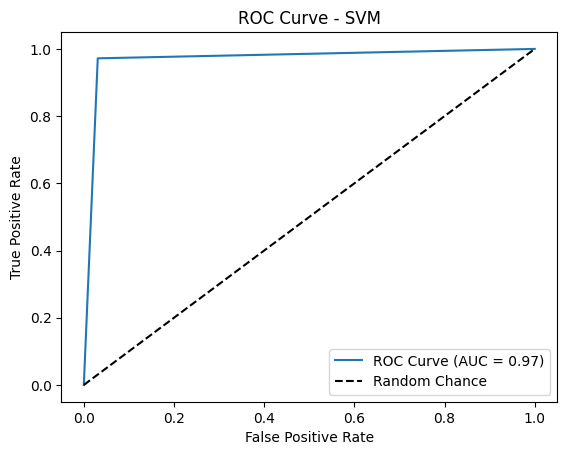

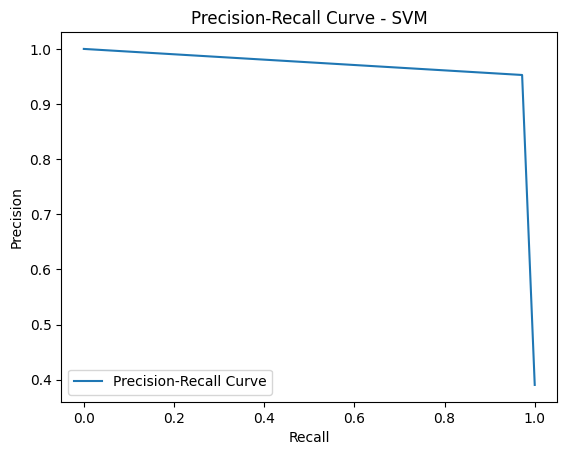

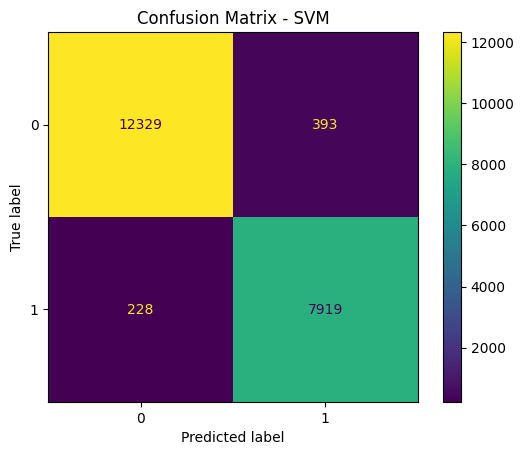

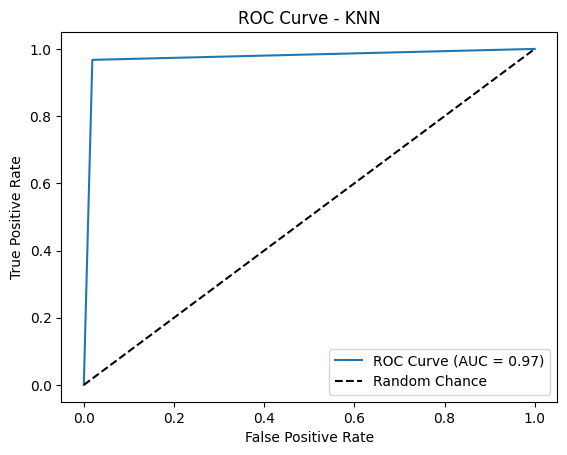

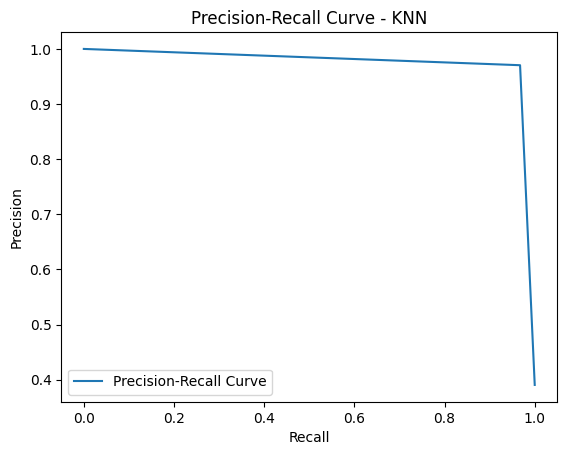

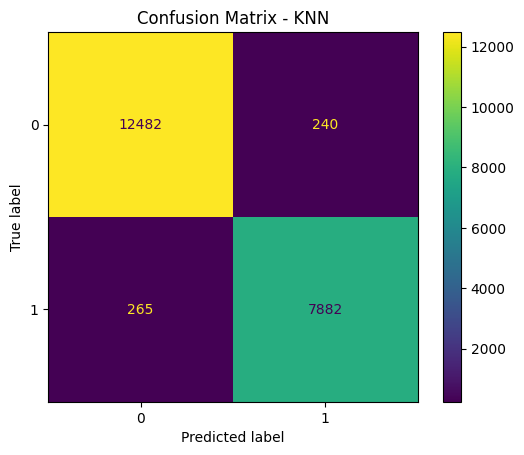

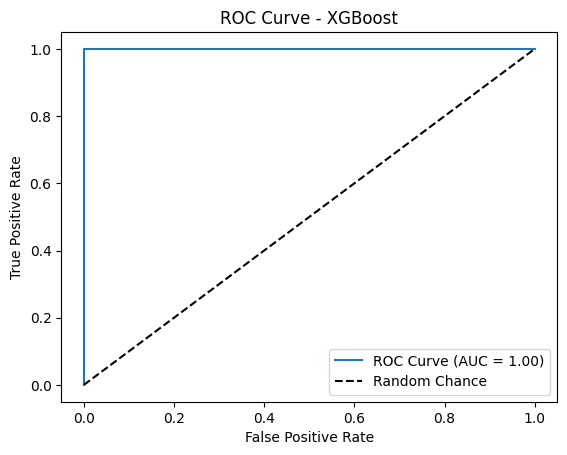

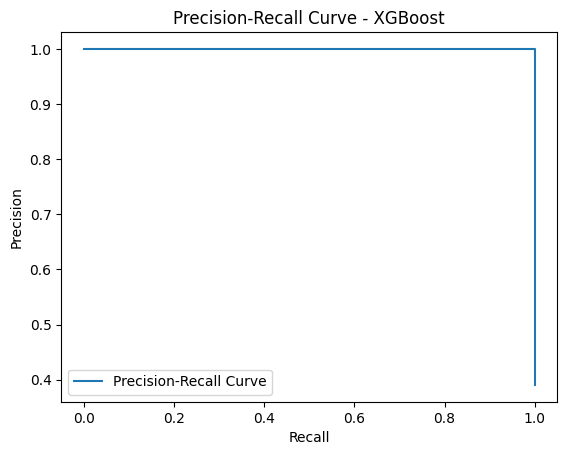

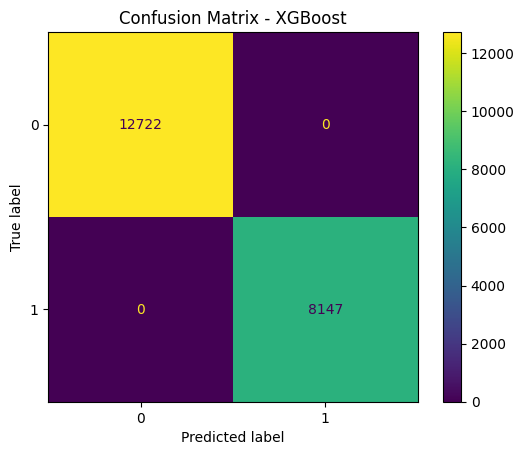

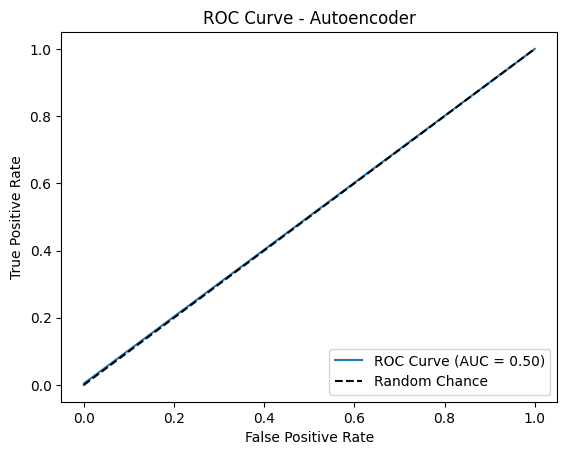

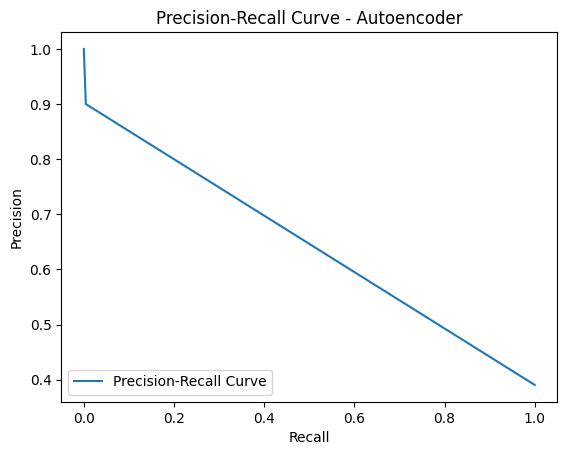

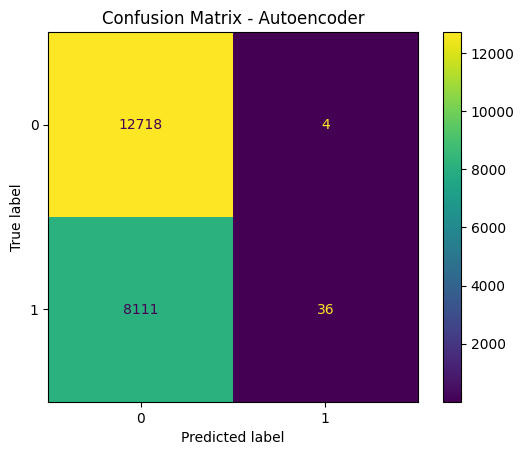

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Function to plot the ROC curve
def plot_roc_curve(y_test, y_preds, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(y_test, y_preds, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_preds)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.show()

# Function to plot the Confusion Matrix
def plot_confusion_matrix(y_test, y_preds, model_name):
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Apply visualization functions to machine learning models
ml_models = {
    "Random Forest": rf_preds,
    "SVM": svm_preds,
    "KNN": knn_preds,
    "XGBoost": xgb_preds,
    "Autoencoder": autoencoder_preds,
}

print("Visualizing Machine Learning Models:")
for model_name, y_preds in ml_models.items():
    plot_roc_curve(y_test, y_preds, model_name)
    plot_precision_recall_curve(y_test, y_preds, model_name)
    plot_confusion_matrix(y_test, y_preds, model_name)



653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Visualizing Deep Learning Models:


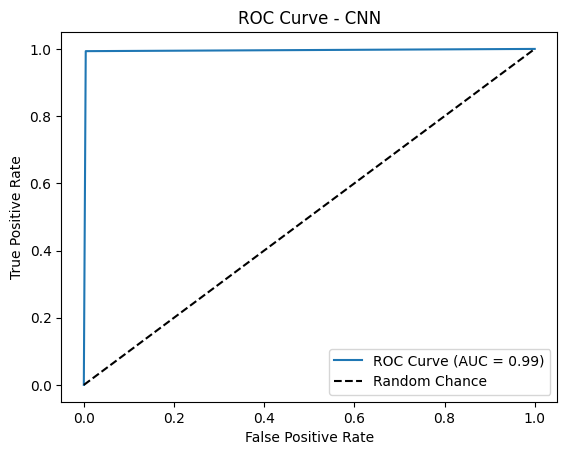

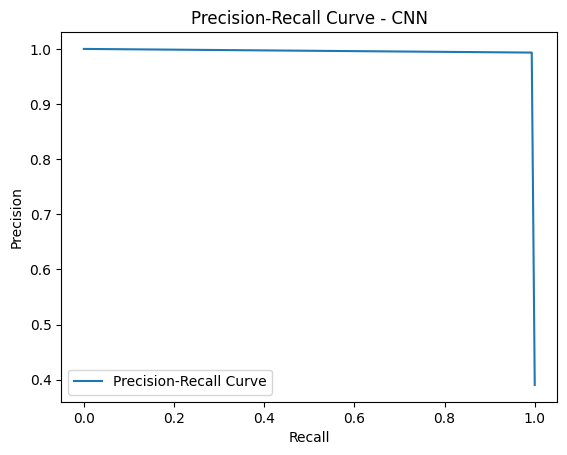

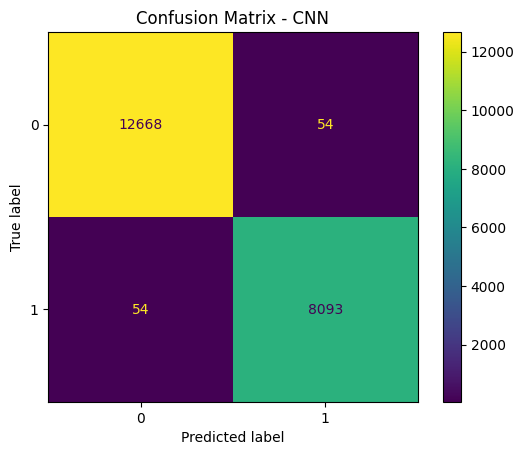

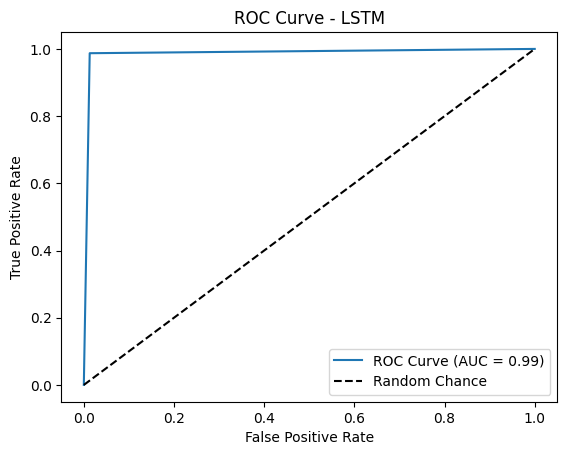

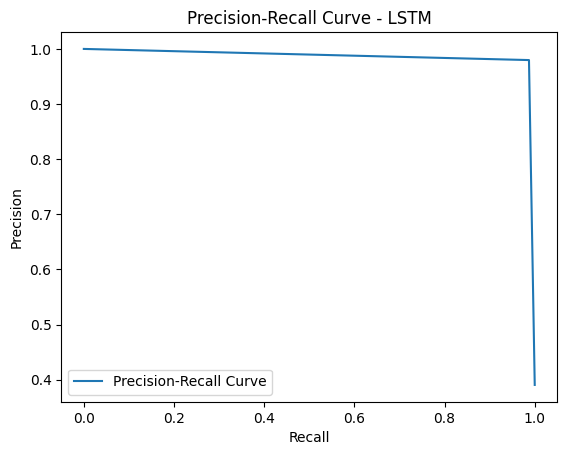

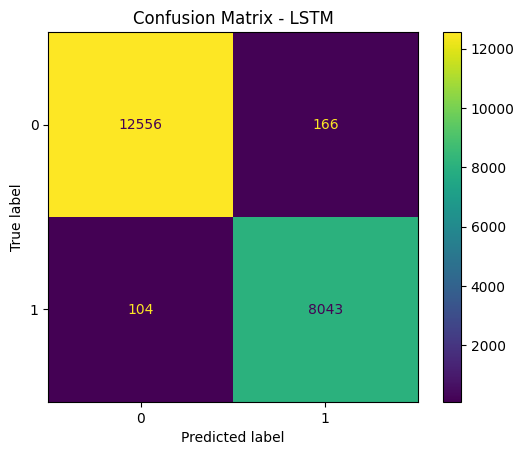

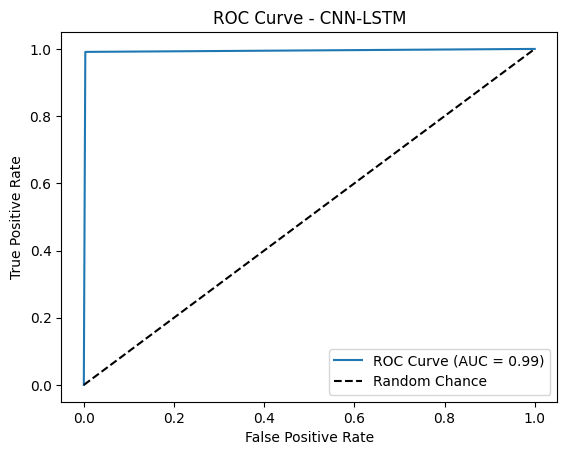

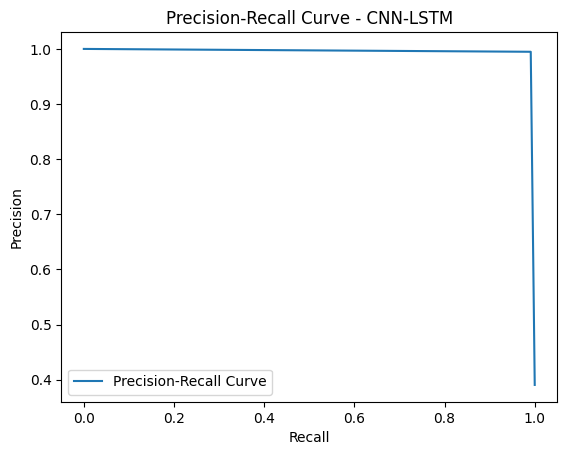

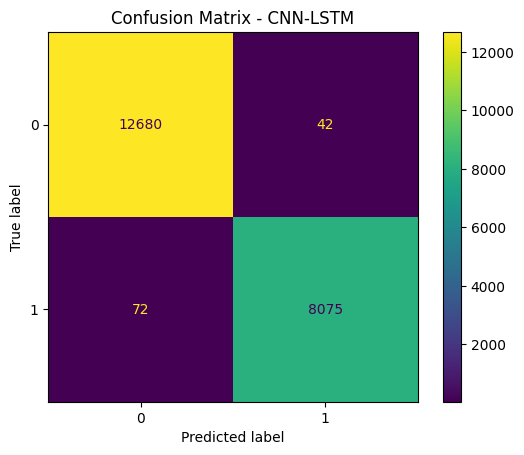

In [ ]:
# For deep learning models (adjust predictions for sigmoid activation)
dl_models = {
    "CNN": (cnn_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten(),
    "LSTM": (lstm_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten(),
    "CNN-LSTM": (cnn_lstm_model.predict(X_test[..., np.newaxis]) > 0.5).astype(int).flatten(),
}

print("Visualizing Deep Learning Models:")
for model_name, y_preds in dl_models.items():
    plot_roc_curve(y_test, y_preds, model_name)
    plot_precision_recall_curve(y_test, y_preds, model_name)
    plot_confusion_matrix(y_test, y_preds, model_name)


Epoch 1/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9946 - loss: 0.0163 - val_accuracy: 0.9939 - val_loss: 0.0172
Epoch 2/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9951 - loss: 0.0136 - val_accuracy: 0.9934 - val_loss: 0.0217
Epoch 3/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9949 - loss: 0.0163 - val_accuracy: 0.9945 - val_loss: 0.0154
Epoch 4/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9951 - loss: 0.0119 - val_accuracy: 0.9965 - val_loss: 0.0103
Epoch 5/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9960 - val_loss: 0.0102
Epoch 6/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9962 - loss: 0.0109 - val_accuracy: 0.9938 - val_loss: 0.0173
Epoch 7/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9958 - loss: 0.0137 - val_accuracy: 0.9973 - val_loss: 0.0087
Epoch 8/10
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9964 - loss: 0.0100

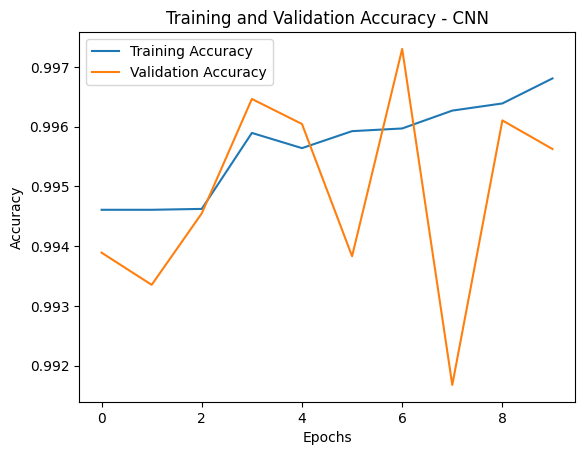

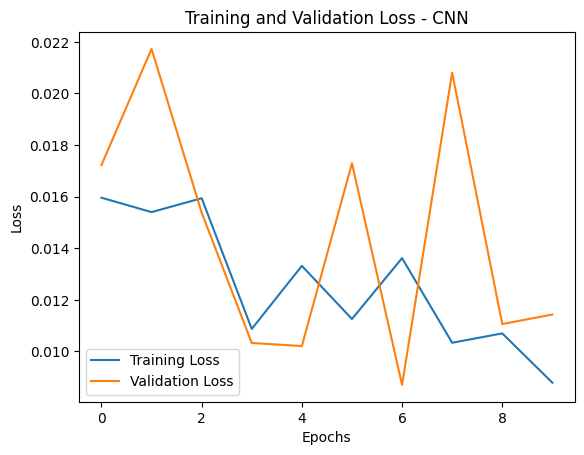

Visualizing Training and Validation Accuracy/Loss for LSTM:


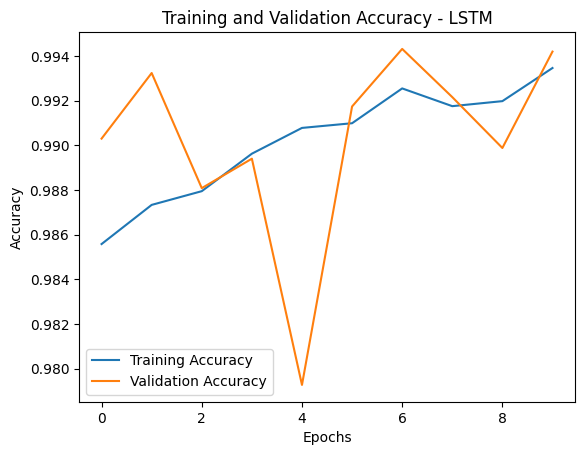

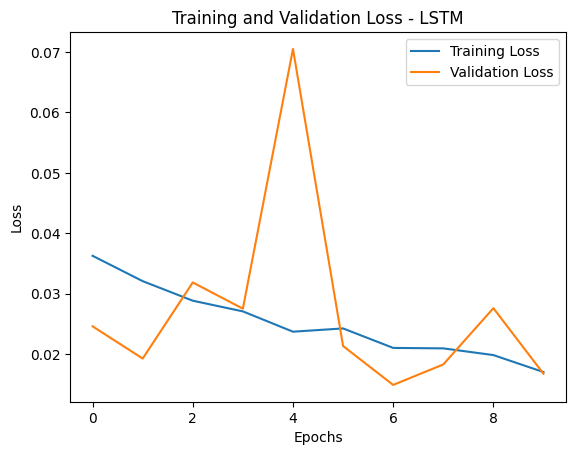

Visualizing Training and Validation Accuracy/Loss for CNN-LSTM:


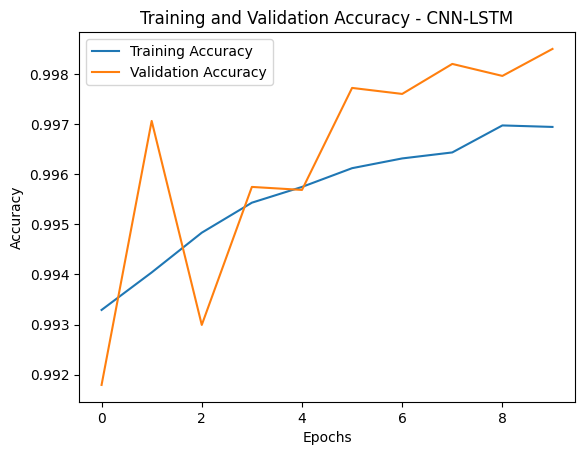

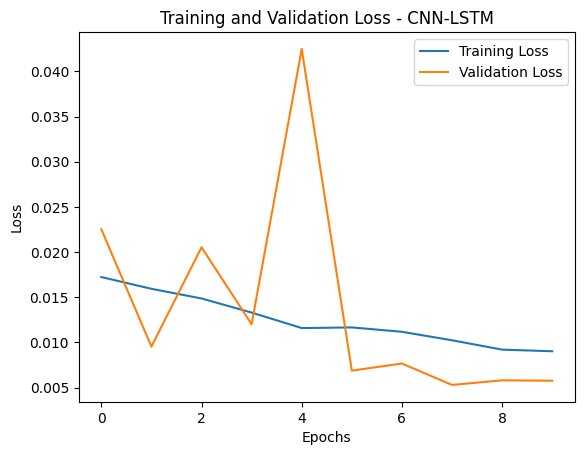

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy
def plot_accuracy(history, model_name):
    plt.figure()
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    else:  # For older TensorFlow/Keras versions, 'acc' might be used instead of 'accuracy'
        plt.plot(history.history['acc'], label='Training Accuracy')
        plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to plot training and validation loss
def plot_loss(history, model_name):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Train models and save history
cnn_history = cnn_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
lstm_history = lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
cnn_lstm_history = cnn_lstm_model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Visualize Training and Validation Accuracy/Loss for each model
print("Visualizing Training and Validation Accuracy/Loss for CNN:")
plot_accuracy(cnn_history, "CNN")
plot_loss(cnn_history, "CNN")

print("Visualizing Training and Validation Accuracy/Loss for LSTM:")
plot_accuracy(lstm_history, "LSTM")
plot_loss(lstm_history, "LSTM")

print("Visualizing Training and Validation Accuracy/Loss for CNN-LSTM:")
plot_accuracy(cnn_lstm_history, "CNN-LSTM")
plot_loss(cnn_lstm_history, "CNN-LSTM")


Visualizing Machine Learning Model Accuracies:


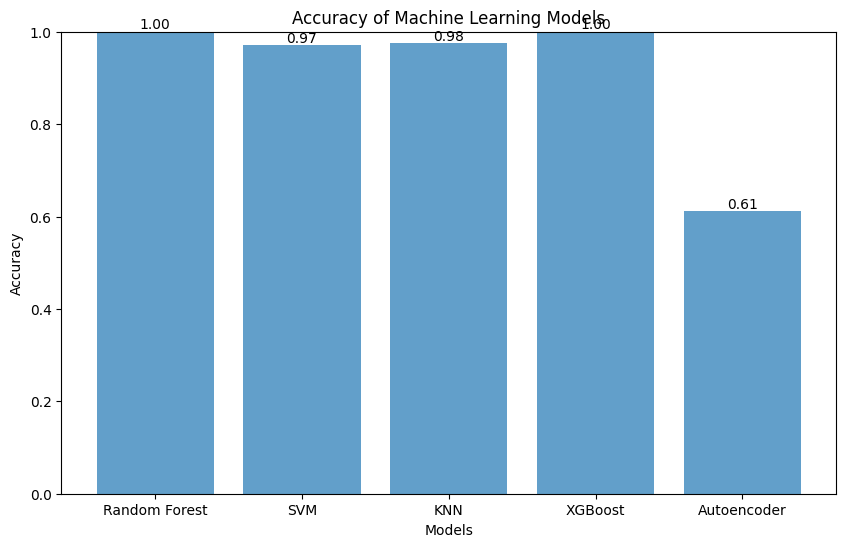

Visualizing Deep Learning Model Accuracies:


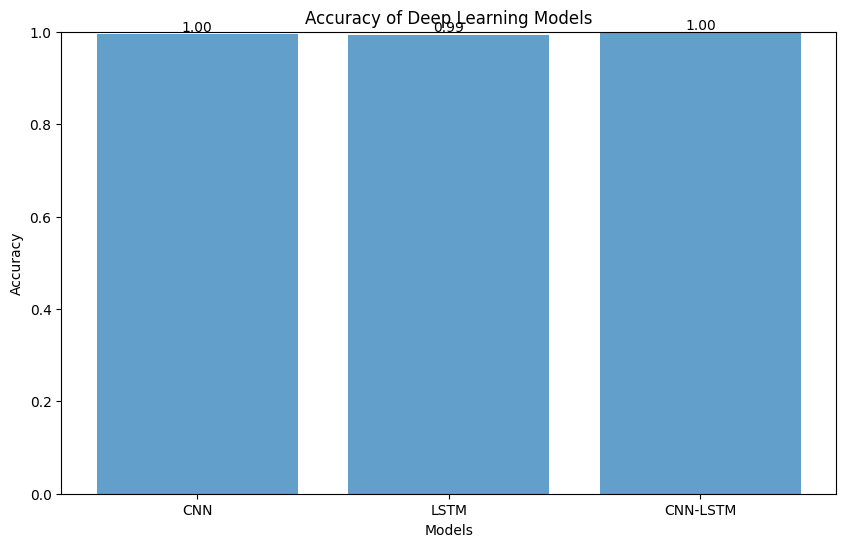

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to plot accuracies of all models
def plot_model_accuracies(model_accuracies, title):
    plt.figure(figsize=(10, 6))
    plt.bar(model_accuracies.keys(), model_accuracies.values(), alpha=0.7)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    for model, accuracy in model_accuracies.items():
        plt.text(model, accuracy, f'{accuracy:.2f}', ha='center', va='bottom')
    plt.show()

# Calculate Machine Learning Model Accuracies
ml_model_accuracies = {
    "Random Forest": accuracy_score(y_test, rf_preds),
    "SVM": accuracy_score(y_test, svm_preds),
    "KNN": accuracy_score(y_test, knn_preds),
    "XGBoost": accuracy_score(y_test, xgb_preds),
    "Autoencoder": accuracy_score(y_test, autoencoder_preds),
}

# Plot ML Model Accuracies
print("Visualizing Machine Learning Model Accuracies:")
plot_model_accuracies(ml_model_accuracies, "Accuracy of Machine Learning Models")

# Calculate Deep Learning Model Accuracies
dl_model_accuracies = {
    "CNN": cnn_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1],
    "LSTM": lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1],
    "CNN-LSTM": cnn_lstm_model.evaluate(X_test[..., np.newaxis], y_test, verbose=0)[1],
}

# Plot DL Model Accuracies
print("Visualizing Deep Learning Model Accuracies:")
plot_model_accuracies(dl_model_accuracies, "Accuracy of Deep Learning Models")


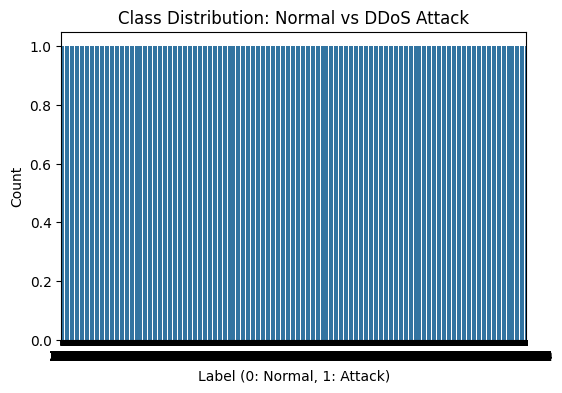

<ipython-input-26-d1a028855f82>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


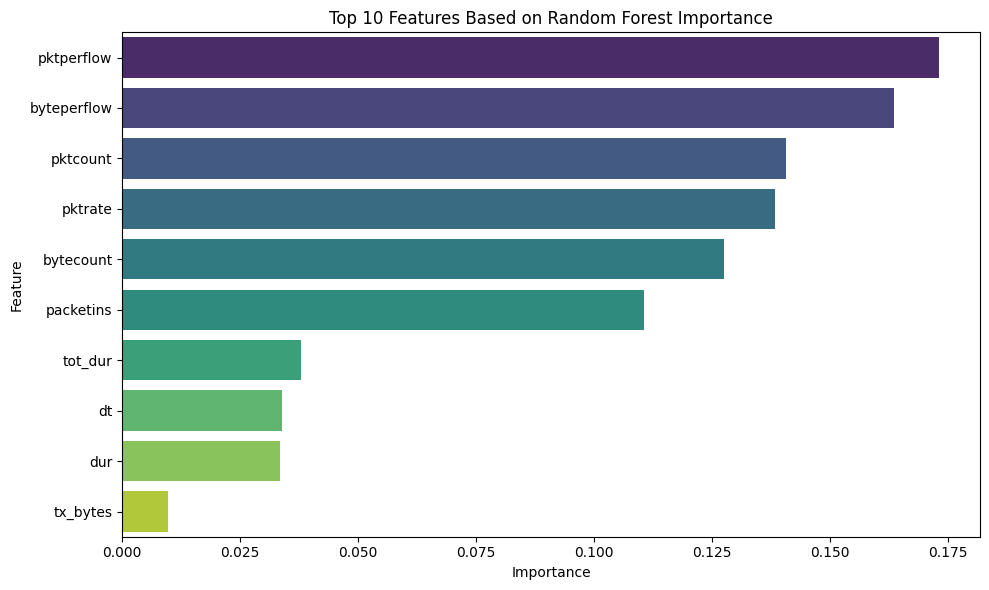

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Preprocessing: Ensure the dataset is numeric and clean
X = data.drop(columns=['label', 'src', 'dst', 'Protocol'], errors='ignore')
y = data['label']

# Train a Random Forest model for feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importance and select the top 10 features
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# 1. Class Distribution Visualization
plt.figure(figsize=(6, 4))
sns.countplot(data['label'])
plt.title('Class Distribution: Normal vs DDoS Attack')
plt.xlabel('Label (0: Normal, 1: Attack)')
plt.ylabel('Count')
plt.show()

# 2. Top 10 Feature Importance Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Top 10 Features Based on Random Forest Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Converted Syn-testing.parquet to CSV.
Converted SNMP-testing.parquet to CSV.
Converted NTP-testing.parquet to CSV.
Converted DNS-testing.parquet to CSV.
Converted NetBIOS-testing.parquet to CSV.
Converted NetBIOS-training.parquet to CSV.
Converted LDAP-training.parquet to CSV.
Converted Syn-training.parquet to CSV.
Converted MSSQL-testing.parquet to CSV.
Converted Portmap-training.parquet to CSV.
Converted MSSQL-training.parquet to CSV.
Converted LDAP-testing.parquet to CSV.
Converted TFTP-testing.parquet to CSV.
Converted UDP-training.parquet to CSV.
Converted UDPLag-testing.parquet to CSV.
Converted UDP-testing.parquet to CSV.
Converted UDPLag-training.parquet to CSV.
Dataset Shape: (431371, 79)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431371 entries, 0 to 431370
Data columns (total 79 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  431371 non-null  int64  


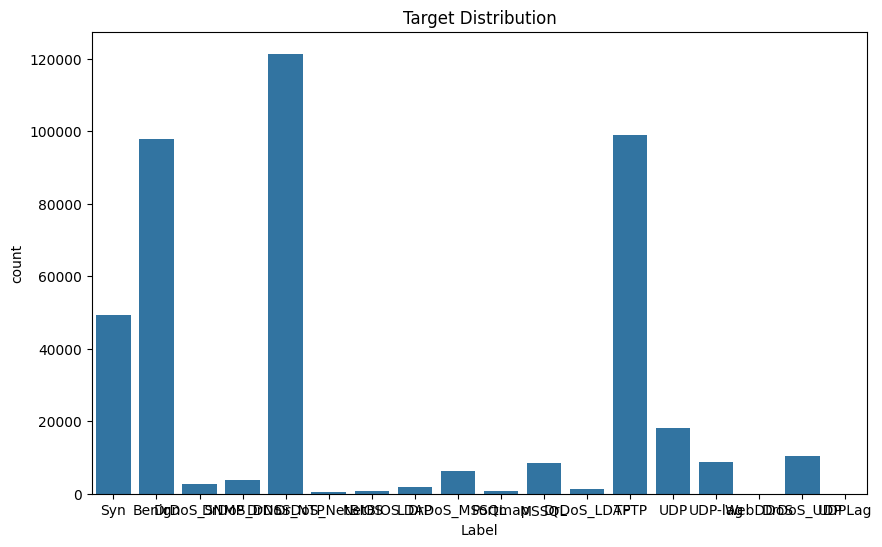

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1/10
6109/6109 ━━━━━━━━━━━━━━━━━━━━ 1375s 224ms/step - accuracy: 0.5084 - loss: -2700038.2500 - val_accuracy: 0.4693 - val_loss: -22039286.0000 - learning_rate: 0.0010
Epoch 2/10
6109/6109 ━━━━━━━━━━━━━━━━━━━━ 1460s 234ms/step - accuracy: 0.5296 - loss: -31076836.0000 - val_accuracy: 0.4918 - val_loss: -74657528.0000 - learning_rate: 0.0010
Epoch 3/10
2136/6109 ━━━━━━━━━━━━━━━━━━━━ 14:00 212ms/step - accuracy: 0.5377 - loss: -74697472.0000

In [ ]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Attention

# Function for Converting Parquet to CSV
def convert_parquet_to_csv(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for file in os.listdir(input_dir):
        if file.endswith(".parquet"):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file.replace(".parquet", ".csv"))
            data = pd.read_parquet(input_path)
            data.to_csv(output_path, index=False)
            print(f"Converted {file} to CSV.")

# Function for Loading Data
def load_data(csv_dir):
    dataframes = []
    for file in os.listdir(csv_dir):
        if file.endswith(".csv"):
            file_path = os.path.join(csv_dir, file)
            df = pd.read_csv(file_path)
            df['source_file'] = file
            dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# Function for Exploratory Data Analysis
def exploratory_data_analysis(data):
    print("Dataset Shape:", data.shape)
    print("Dataset Info:")
    print(data.info())
    print("Missing Values:", data.isnull().sum())
    print("Target Distribution:")
    print(data['Label'].value_counts())
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Label', data=data)
    plt.title("Target Distribution")
    plt.show()

# Preprocessing Function
def preprocess_data(data):
    data = data.dropna()  # Handle missing values
    for col in data.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])  # Encode categorical data
    scaler = StandardScaler()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])  # Scale numerical data
    return data

# Feature Engineering
def feature_engineering(data):
    if 'FlowDuration' in data.columns and 'TotalPackets' in data.columns:
        data['flow_rate'] = data['FlowDuration'] / (data['TotalPackets'] + 1e-9)
    return data

# Splitting Data
def split_data(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Advanced CNN-LSTM Model
def create_advanced_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Corrected Main Execution
input_dir = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/CICDDoS2019'
output_dir = '/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/ddos_csv'

# Step 1: Convert Parquet to CSV
convert_parquet_to_csv(input_dir, output_dir)

# Step 2: Load Data
csv_dir = output_dir
data = load_data(csv_dir)

# Step 3: Exploratory Data Analysis
exploratory_data_analysis(data)

# Step 4: Preprocess Data
data = preprocess_data(data)

# Step 5: Feature Engineering
data = feature_engineering(data)

# Step 6: Ensure the Target Column is Categorical
target_column = 'Label'  # Replace with the actual target column
data[target_column] = data[target_column].astype(int)  # Ensure integer encoding

# Step 7: Split Data
X_train, X_test, y_train, y_test = split_data(data, target_column)

# Step 8: Handle Imbalanced Data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 9: Reshape Data for CNN-LSTM
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 10: Advanced CNN-LSTM Model
def create_advanced_cnn_lstm_model(input_shape):
    from tensorflow.keras import Input
    model = Sequential([
        Input(shape=input_shape),  # Updated to use Input layer
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        Bidirectional(LSTM(64, return_sequences=True)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_advanced_cnn_lstm_model(input_shape=(X_train.shape[1], 1))

# Step 11: Train Model with Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)  # Updated filepath
]

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=callbacks)

# Step 12: Evaluate Model
predictions = (model.predict(X_test) > 0.5).astype(int)  # Convert predictions to binary
print(classification_report(y_test, predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, predictions))

# Step 13: Visualization of Results
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


